In [3]:
#kaggle notebook
!pip install torchsummary
!pip install --upgrade torch torchvision torchaudio
!pip install py7zr
!pip install pytorch-model-summary

In [4]:
#imports
from pathlib import Path
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import sys

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import IPython.display as ipd
from matplotlib.pyplot import figure


from pytorch_model_summary import summary as summ

from tqdm import tqdm

import librosa
import random
import shutil

import warnings

In [6]:
print(torch.__version__)

1.11.0+cu102


In [7]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
!python -m py7zr x ../input/tensorflow-speech-recognition-challenge/train.7z #kaggle notebook

In [9]:
!python -m py7zr x ../input/tensorflow-speech-recognition-challenge/test.7z #kaggle notebook

In [12]:
all_classes = ['one','go', 'two', 'seven', 'bird', 'eight', 'right', 'off', 'yes',
       'stop', 'left', 'nine', 'cat', 'dog','three','on', 'zero', 'five', 'sheila','happy', 'wow', 'six' ,'house', 'marvin','no','four', 'tree' ,'down','bed','up']
classes =[ "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
no_classes = list(set(all_classes) -  set(classes))
special_classes = ["silence", "unknown"] 

In [17]:
#https://pytorch.org/audio/stable/_modules/torchaudio/datasets/speechcommands.html
def load_speechcommands_item( path: str,filepath: str):
    label, filename = os.path.split(filepath)
    waveform, sample_rate = torchaudio.load(path +'/'+ filepath)    
    return label, waveform, sample_rate
    
def _load_folder_list(root):
    return  list(str(p)[len(root)- 1:] for p in Path(root).glob("*/*.wav"))


class _SpeechSubset(Dataset):
    def __init__(self, root, subset, transformation = None):
        self.root = root
        self.subset = subset
        self.transformation = transformation
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        filepath = self.subset[idx]
        label, waveform, sample_rate = load_speechcommands_item(self.root, filepath)
        if self.transformation is not None:
            label, waveform, sample_rate = self.transformation(label, waveform, sample_rate)
        return waveform, sample_rate, label,
    

        
    

class SpeechDataset():
    def __init__(self, root, train_size = None, exclude = None, transformation = None, ):
        self.root = root
        self.train_size = train_size
        self.transformation = transformation
        self.dataset = _load_folder_list(self.root)
        
        if exclude is not None:
            self.dataset = [x for x in self.dataset if exclude(x) == False]
            
        if self.train_size is not None:
            self.train_subset, self.val_subset = train_test_split(self.dataset, train_size=self.train_size)
     
    def __getSubset(self, name):
        if name == "train":
            return _SpeechSubset(self.root, self.train_subset, transformation = self.transformation)
        elif name == "val":
            return _SpeechSubset(self.root, self.val_subset, transformation = self.transformation)
        elif name == "train+val":
            return _SpeechSubset(self.root,  self.dataset, transformation = self.transformation)
        else:
            return None
            
    def getTrainSubset(self,):
        return self.__getSubset("train")
    
    def getValidationSubset(self):
        return self.__getSubset("val")
    
    def getTrainValidationSubset(self):
        return self.__getSubset("train+val")
    
    def getFilenames(self):
        return self.dataset

In [14]:
dataset_noise = SpeechDataset("./train/audio",None, exclude = lambda x: x.startswith('_background_noise_') == False)

whole_set_noise = dataset_noise.getTrainValidationSubset()

In [15]:
dataset_noise.getFilenames()

['_background_noise_/dude_miaowing.wav',
 '_background_noise_/pink_noise.wav',
 '_background_noise_/running_tap.wav',
 '_background_noise_/exercise_bike.wav',
 '_background_noise_/white_noise.wav',
 '_background_noise_/doing_the_dishes.wav']

(torch.Size([1, 988891]), 0.75177, 61.8056875)

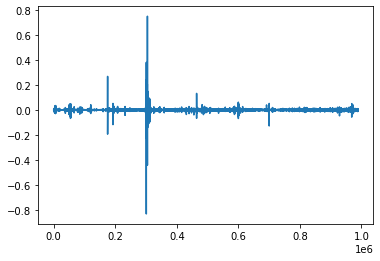

In [18]:
waveform, sample_rate, label,= whole_set_noise[0]

plt.plot(waveform.t().numpy());
waveform.shape, waveform.t().numpy().max(), len(waveform[0]) / 16000

In [19]:
shutil.rmtree('./train/audio/silence', ignore_errors=True)
Path("./train/audio/silence").mkdir(parents=True, exist_ok=True)

low_sum_by_second = 0.5

max_ratio_level = 1
multiplication = 5


for z,(w,s,l) in enumerate(whole_set_noise):
    min_val = len(w[0]) / (s * float(w[0].abs().sum())) * low_sum_by_second
    step = (max_ratio_level - min_val) / multiplication
    print()
    for i in range(multiplication +1):
        ratio = min_val + step * i
        wave = w * ratio
        wave_split = wave.split(16000, dim = 1)
        for j,w1 in enumerate(wave_split):
            Path("./train/audio/silence").mkdir(parents=True, exist_ok=True)
            torchaudio.save('./train/audio/silence/'+str(z) + "_" +str(i) + "_" + str(j)+'.wav', w1, 16000)

In [20]:
dataset_silence = SpeechDataset("./train/audio",None, exclude = lambda x: x.startswith('silence') == False)


whole_set_silence = dataset_silence.getTrainValidationSubset()


In [21]:
len(whole_set_silence)

2412

In [23]:
def unkownTransformation(label, waveform, sample_rate):
    if label in no_classes:
        label = "unknown"
    return label, waveform, sample_rate

In [24]:
dataset = SpeechDataset("./train/audio",0.7, exclude = lambda x: x.startswith('_background_noise_'),transformation = unkownTransformation)

train_set = dataset.getTrainSubset()
val_set = dataset.getValidationSubset()
whole_set = dataset.getTrainValidationSubset()


46993 20140 67133


torch.Size([1, 16000])

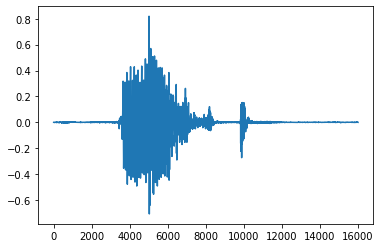

In [25]:

print(len(train_set), len(val_set), len(whole_set))

waveform, sample_rate, label,= train_set[0]

plt.plot(waveform.t().numpy());
waveform.shape

In [120]:
labels = special_classes + classes
labels

['silence',
 'unknown',
 'yes',
 'no',
 'up',
 'down',
 'left',
 'right',
 'on',
 'off',
 'stop',
 'go']

In [32]:
unique, counts = np.unique([x[2] for x in whole_set], return_counts=True)
result = np.column_stack((unique, counts))
result.sort(axis = 1)
result

array([['2359', 'down'],
       ['2372', 'go'],
       ['2353', 'left'],
       ['2375', 'no'],
       ['2357', 'off'],
       ['2367', 'on'],
       ['2367', 'right'],
       ['2412', 'silence'],
       ['2380', 'stop'],
       ['41039', 'unknown'],
       ['2375', 'up'],
       ['2377', 'yes']], dtype='<U21')

In [33]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(2) --> yes


In [34]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)




def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label  in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)
val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        
        return x


model = M5(n_input=1, n_output=len(labels)).cuda()

In [ ]:
from torch.autograd import Variable 
class LSTM1(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size = 2, num_layers = 8):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(496, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda() #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda() #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0,c_0)) #lstm with input, hidden, and internal state
        output = output.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = 0.5)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate LSTM
        out, (h,c) = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = h[-1, :, :]
        out = self.fc(out)
        out = F.dropout(out, 0.3)
        return out

In [35]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(1, 32, kernel_size=80, stride=4)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=16, stride=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(980, hidden_size, num_layers, batch_first=True, dropout = 0.3)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = F.dropout(x, 0.2)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        #x= self.pool2(x)
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # Forward propagate LSTM
        out, (h,c) = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        out = self.fc1(out)
        out = F.dropout(out, 0.3)
        out = self.fc(out)
        return out

In [36]:
model4 = RNN2(16000, 512, 4, len(labels)).cuda()

In [121]:
print(summ(model4, torch.zeros((64,1,16000)).cuda(), show_input=False))

-------------------------------------------------------------------------------------------------
      Layer (type)                                  Output Shape         Param #     Tr. Param #
          Conv1d-1                                [64, 32, 3981]           2,592           2,592
     BatchNorm1d-2                                [64, 32, 3981]              64              64
       MaxPool1d-3                                 [64, 32, 995]               0               0
          Conv1d-4                                 [64, 64, 980]          32,832          32,832
     BatchNorm1d-5                                 [64, 64, 980]             128             128
            LSTM-6     [64, 64, 512], [4, 64, 512], [4, 64, 512]       9,363,456       9,363,456
          Linear-7                                     [64, 128]          65,664          65,664
          Linear-8                                      [64, 12]           1,548           1,548
Total params: 9,466,284
Train

In [122]:
print(summ(model4, torch.zeros((64,1,16000)).cuda(), show_input=True))

-------------------------------------------------------------------------------------------------
      Layer (type)                                   Input Shape         Param #     Tr. Param #
          Conv1d-1                                [64, 1, 16000]           2,592           2,592
     BatchNorm1d-2                                [64, 32, 3981]              64              64
       MaxPool1d-3                                [64, 32, 3981]               0               0
          Conv1d-4                                 [64, 32, 995]          32,832          32,832
     BatchNorm1d-5                                 [64, 64, 980]             128             128
            LSTM-6     [64, 64, 980], [4, 64, 512], [4, 64, 512]       9,363,456       9,363,456
          Linear-7                                     [64, 512]          65,664          65,664
          Linear-8                                     [64, 128]           1,548           1,548
Total params: 9,466,284
Train

In [ ]:
class UnkownPerformanceMetric():
    def __init__(self, classes):
        self.classes_indexes = torch.tensor([label_to_index(x) for x in classes])
        self.correct = 0
        self.count = 0
    
    def insert(self, input, target):
        indices_input = torch.cat([(input == i).nonzero() for i in self.classes_indexes])
        input[indices_input] = -1
        indices_target = torch.cat([(target == i).nonzero() for i in self.classes_indexes])
        target[indices_target] = -1
        
        values = (input==target)
        self.correct += values.sum().item()
        self.count += len(values)
        
    def print(self, reset = True):
        agg = self.correct / self.count
        print("UnkownPerformanceMetric: ", agg)
        if reset:
            self.reset()
        
    def reset(self):
        self.correct = 0
        self.count = 0
        
metrics1 = UnkownPerformanceMetric(no_classes)

In [37]:
class NotUnkownPerformanceMetric():
    def __init__(self, unkownIndex):
        self.unkownIndex = unkownIndex
        self.correct = 0
        self.count = 0
    
    def insert(self, input, target):
        mask = target != self.unkownIndex
        indices = torch.nonzero(mask)
        values = (input==target)[indices]
        self.correct += values.sum().item()
        self.count += len(values)
        
    def print(self, reset = True):
        agg = self.correct / self.count
        print("NotUnkownPerformance: ", agg)
        if reset:
            self.reset()
        
    def reset(self):
        self.correct = 0
        self.count = 0
        
metrics = NotUnkownPerformanceMetric(int(label_to_index("unknown")))

In [38]:
weight = torch.tensor([6.])
weight = weight.repeat(12)
weight[int(label_to_index("unknown"))] = 1.
weight = weight.cuda()

In [39]:
def train(model, train_dataloader, test_dataloader = None, num_epochs=1, lr=1e-3, keepBest = False, metrics = None, weight = None, augumentation = None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)  

    acc_train = np.empty([0])
    acc_val = np.empty([0])

    best_model_wts = None
    best_acc = None

    for epoch in range(num_epochs):
        correct_train = 0
        model.train()
        
        with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
            for batch_idx, train_batch in epoch_progress:
                x, y = train_batch      
                x = x.cuda()
                y = y.cuda()
                if augumentation is not None:
                    x = augumentation(x)
                logits = model(x)

                loss = F.cross_entropy(logits.squeeze(), y, weight = weight)
                logits_argmax = logits.argmax(dim = -1).squeeze()
                epoch_correct = (logits_argmax==y).sum().item()
                                       

                correct_train += epoch_correct
                epoch_progress.set_postfix({'batch acc': epoch_correct / x.shape[0]})  

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        train_cc = correct_train / len(train_dataloader.dataset)
        acc_train = np.append(acc_train,train_cc)
        print("Train acc " + str(train_cc))
        scheduler.step()

        if test_dataloader is not None: 
            with torch.no_grad():
                model.eval()
                correct_val = 0
                for test_batch in tqdm(test_dataloader, desc="Testing"):
                    x, y = test_batch
                    x = x.cuda()
                    y = y.cuda()

                    logits = model(x)

                    logits_argmax = logits.argmax(dim = -1).squeeze()
                    epoch_correct = (logits_argmax==y).sum().item()
                    
                    if metrics is not None:
                        metrics.insert(logits_argmax, y)

                    correct_val += epoch_correct

                val_acc = correct_val / len(test_dataloader.dataset)
                acc_val = np.append(acc_val,val_acc)
                print("Val acc " + str(val_acc))
                
                if metrics is not None:
                    metrics.print()

                if best_acc is None or best_acc < val_acc:
                    best_acc = val_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    if keepBest and test_dataloader is not None:
        model.load_state_dict(best_model_wts)
      
    model.train()
    return acc_train, acc_val

In [40]:
tr_loss, val_los = train(model4, train_loader, val_loader,num_epochs=30, lr = 0.001, keepBest = False, metrics= metrics, weight= weight)

Training (epoch=0/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.559]


Train acc 0.559061987955653


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Val acc 0.49215491559086394
NotUnkownPerformance:  0.21578345406023636


Training (epoch=1/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.531]


Train acc 0.5300151086332007


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


Val acc 0.6445878848063555
NotUnkownPerformance:  0.6163426102427246


Training (epoch=2/30): 100%|██████████| 184/184 [00:38<00:00,  4.74it/s, batch acc=0.717]


Train acc 0.671674504713468


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


Val acc 0.7526812313803376
NotUnkownPerformance:  0.7786249841148811


Training (epoch=3/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.834]


Train acc 0.7560913327516864


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


Val acc 0.8236842105263158
NotUnkownPerformance:  0.7291904943448977


Training (epoch=4/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.8]  


Train acc 0.7900112782754879


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


Val acc 0.817279046673287
NotUnkownPerformance:  0.807726521794383


Training (epoch=5/30): 100%|██████████| 184/184 [00:38<00:00,  4.72it/s, batch acc=0.855]


Train acc 0.8104824122741685


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


Val acc 0.8021350546176763
NotUnkownPerformance:  0.8410217308425467


Training (epoch=6/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.786]


Train acc 0.8309748260379205


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Val acc 0.8303872889771599
NotUnkownPerformance:  0.8439445927055534


Training (epoch=7/30): 100%|██████████| 184/184 [00:39<00:00,  4.72it/s, batch acc=0.883]


Train acc 0.8416998276339029


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.77it/s]


Val acc 0.858987090367428
NotUnkownPerformance:  0.8372093023255814


Training (epoch=8/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.897]


Train acc 0.8563190262379503


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


Val acc 0.8559086395233366
NotUnkownPerformance:  0.8581776591688905


Training (epoch=9/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.855]


Train acc 0.8651288489775073


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


Val acc 0.8612214498510427
NotUnkownPerformance:  0.851823611640615


Training (epoch=10/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.89] 


Train acc 0.8704275104802843


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


Val acc 0.8529294935451837
NotUnkownPerformance:  0.8649129495488627


Training (epoch=11/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.883]


Train acc 0.8820462622092652


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.74it/s]


Val acc 0.883167825223436
NotUnkownPerformance:  0.8481382640742152


Training (epoch=12/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.917]


Train acc 0.8847062328431894


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Val acc 0.8773088381330685
NotUnkownPerformance:  0.8485195069259118


Training (epoch=13/30): 100%|██████████| 184/184 [00:38<00:00,  4.72it/s, batch acc=0.883]


Train acc 0.8930266209861043


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


Val acc 0.8761171797418074
NotUnkownPerformance:  0.8525860973440081


Training (epoch=14/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.903]


Train acc 0.8984955206094525


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.70it/s]


Val acc 0.8780039721946375
NotUnkownPerformance:  0.8663108400050832


Training (epoch=15/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.89] 


Train acc 0.9054752835528695


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


Val acc 0.8985104270109235
NotUnkownPerformance:  0.8669462447579108


Training (epoch=16/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.862]


Train acc 0.906581831336582


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.63it/s]


Val acc 0.8462264150943396
NotUnkownPerformance:  0.8598297115262422


Training (epoch=17/30): 100%|██████████| 184/184 [00:38<00:00,  4.72it/s, batch acc=0.931]


Train acc 0.9121996893154299


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


Val acc 0.8885799404170804
NotUnkownPerformance:  0.8722836446816622


Training (epoch=18/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.89] 


Train acc 0.9183708211861341


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.72it/s]


Val acc 0.8772591857000993
NotUnkownPerformance:  0.882958444529165


Training (epoch=19/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.876]


Train acc 0.9213499882961292


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.75it/s]


Val acc 0.8869910625620655
NotUnkownPerformance:  0.8716482399288347


Training (epoch=20/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.938]


Train acc 0.9209031132296299


Testing: 100%|██████████| 79/79 [00:09<00:00,  7.96it/s]


Val acc 0.8848560079443892
NotUnkownPerformance:  0.8805439064684204


Training (epoch=21/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.903]


Train acc 0.9261379354371928


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.77it/s]


Val acc 0.898609731876862
NotUnkownPerformance:  0.8792730969627652


Training (epoch=22/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.931]


Train acc 0.9334581746217522


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.72it/s]


Val acc 0.9009433962264151
NotUnkownPerformance:  0.8806709874189859


Training (epoch=23/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.91] 


Train acc 0.9315217160002554


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


Val acc 0.8978649453823238
NotUnkownPerformance:  0.8616088448341593


Training (epoch=24/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.917]


Train acc 0.9326495435490392


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


Val acc 0.8876365441906653
NotUnkownPerformance:  0.8767314779514551


Training (epoch=25/30): 100%|██████████| 184/184 [00:39<00:00,  4.71it/s, batch acc=0.952]


Train acc 0.9534398740237908


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.72it/s]


Val acc 0.9145978152929494
NotUnkownPerformance:  0.8914728682170543


Training (epoch=26/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.972]


Train acc 0.9609729108590641


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


Val acc 0.9182720953326713
NotUnkownPerformance:  0.8952852967340196


Training (epoch=27/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.972]


Train acc 0.9656544591747707


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.65it/s]


Val acc 0.9203078450844091
NotUnkownPerformance:  0.8931249205744058


Training (epoch=28/30): 100%|██████████| 184/184 [00:38<00:00,  4.73it/s, batch acc=0.972]


Train acc 0.9683569893388377


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.78it/s]


Val acc 0.9239324726911619
NotUnkownPerformance:  0.8947769729317575


Training (epoch=29/30): 100%|██████████| 184/184 [00:39<00:00,  4.72it/s, batch acc=0.993]


Train acc 0.9695060966526929


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.77it/s]

Val acc 0.9234359483614697
NotUnkownPerformance:  0.8956665395857161


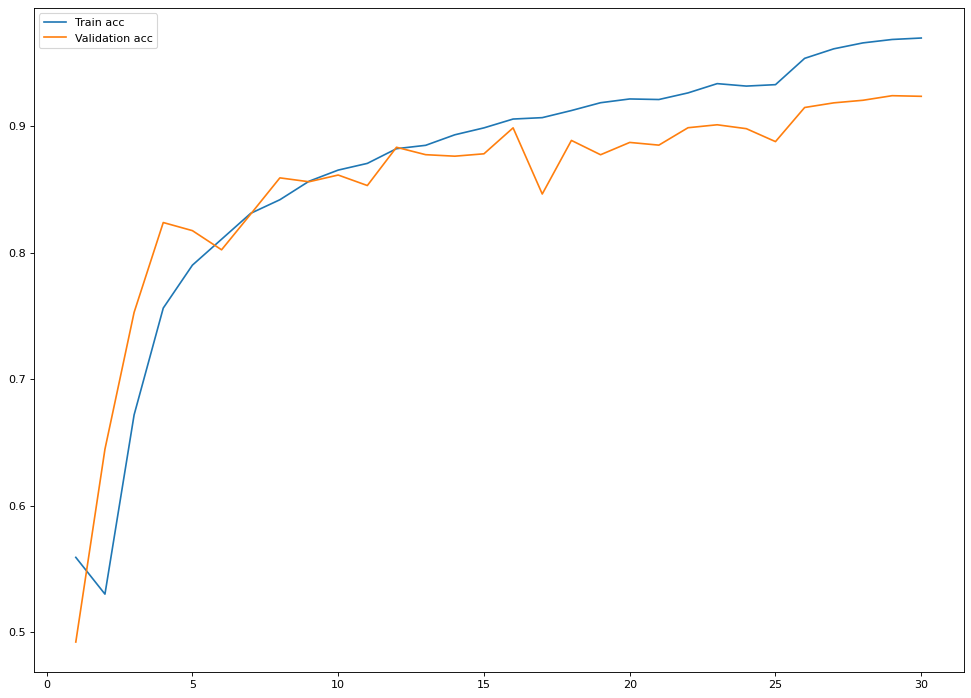

In [41]:
figure(figsize=(15,11), dpi=80)
plt.plot(range(1,31), tr_loss,label = "Train acc")
plt.plot(range(1,31), val_los, label = "Validation acc")
plt.legend()

In [42]:
def prediction(model,test_dataloader):
    with torch.no_grad():
        model.eval()
        prediction = np.empty([0], dtype=np.int8)


        for test_batch in tqdm(test_dataloader, desc="Testing"):
            x, _ = test_batch
            x = x.cuda()
            logits = model(x)
            logits_argmax = logits.argmax(dim = -1).squeeze()
            prediction = np.append(prediction,logits_argmax.cpu().numpy())
    return prediction

In [43]:
from sklearn.metrics import confusion_matrix

pred_val = prediction(model4, val_loader)

true_labels = [label_to_index(x[2]) for x in val_set]

cm = confusion_matrix(pred_val, true_labels)


Testing: 100%|██████████| 79/79 [00:10<00:00,  7.63it/s]


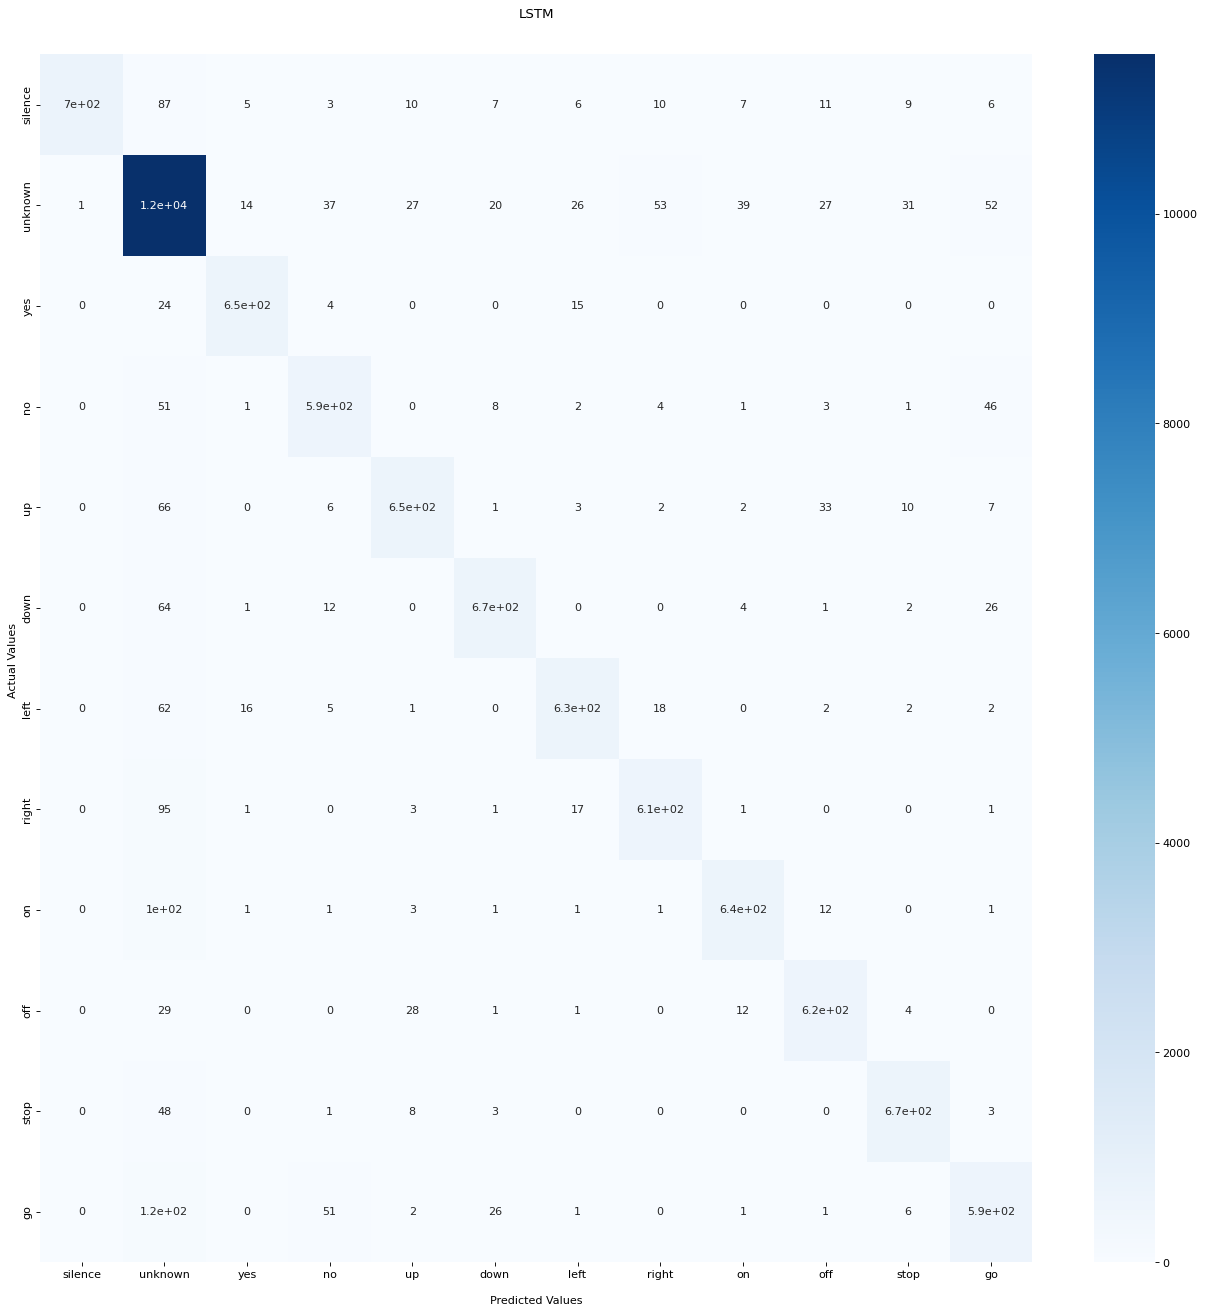

In [44]:
import seaborn as sns

figure(figsize=(20,20), dpi=80)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('LSTM\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([index_to_label(x) for x in range(len(labels))])
ax.yaxis.set_ticklabels([index_to_label(x) for x in range(len(labels))])

## Display the visualization of the Confusion Matrix.
plt.show()

In [45]:
def getSoftMax(model, dataloader):
    with torch.no_grad():
        model.eval()
        outputs = []
        for x,y in dataloader:
            x = x.cuda()
            outputs.append(F.softmax(model(x),dim=1).cpu())
    return torch.cat(outputs, dim=0)
        

In [46]:
whole_loader_noshuffle = DataLoader(
    whole_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

train_loader_noshuffle = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_loader_noshuffle = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [47]:
softmaxs_train = getSoftMax(model4, train_loader_noshuffle)
softmaxs_val = getSoftMax(model4, val_loader_noshuffle)
softmaxs_whole = getSoftMax(model4, whole_loader_noshuffle)

In [49]:
softmaxs_val_copy = copy.deepcopy(list(softmaxs_val.numpy()))
a = sorted(list(range(len(softmaxs_val_copy))),key = lambda x : (
    softmaxs_val_copy[x].sort(),
   softmaxs_val_copy[x][-2]
))
a[-10:]

[12668, 3265, 185, 19075, 5312, 16078, 837, 15305, 11021, 11045]

In [126]:
cor = 0
wrong = 0

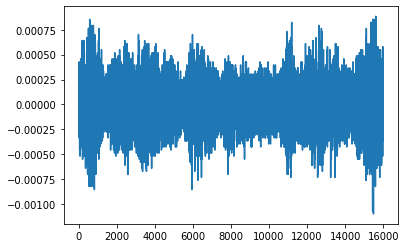

12349
down
tensor([0.5986, 0.0607, 0.0181, 0.0347, 0.0481, 0.0252, 0.0291, 0.0370, 0.0375,
        0.0286, 0.0316, 0.0508])


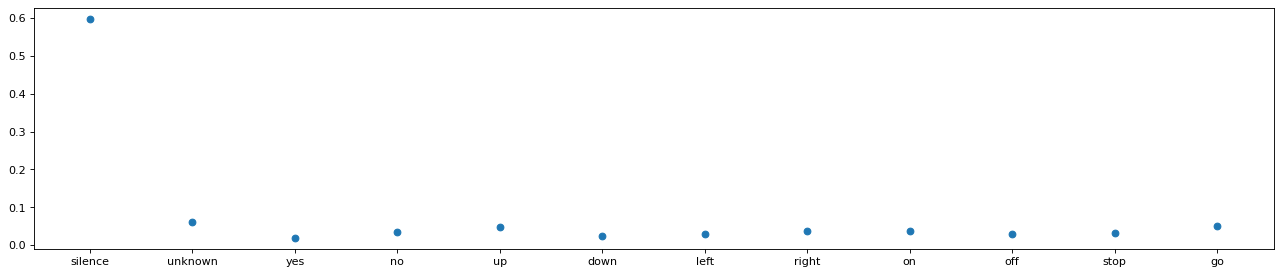

Predition silence
Accuracy 0.875


In [137]:
while True:
    index = random.randint(0, len(val_set))
    waveform, sample_rate, label,= val_set[index]
    logits_argmax = softmaxs_val[index].argmax(dim = -1).squeeze()
    if label !=  index_to_label(int(logits_argmax)):
        wrong += 1
        break
    cor +=1
    

plt.plot(waveform.t().numpy());
plt.show()
waveform.shape


import IPython

print(index)
print(label)
print(softmaxs_val[index])
figure(figsize=(20, 4), dpi=80)
plt.scatter([index_to_label(i) for i in range(0,len(softmaxs_val[index]))],softmaxs_val[index])
plt.show()
logits_argmax = softmaxs_val[index].argmax(dim = -1).squeeze()
print("Predition", index_to_label(int(logits_argmax)))
print("Accuracy", cor / (cor + wrong))
torchaudio.save('a.wav', waveform, 16000)
IPython.display.Audio("a.wav")


In [53]:
whole_loader = DataLoader(
    whole_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [54]:
model4 = RNN2(16000, 512, 4, len(labels)).cuda()

In [55]:
tr_loss, val_los = train(model4, whole_loader, num_epochs=30, lr = 0.001, keepBest = False, metrics= metrics, weight = weight)

Training (epoch=0/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.426]


Train acc 0.5279072885168248


Training (epoch=1/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.738]


Train acc 0.64276883202002


Training (epoch=2/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.738]


Train acc 0.7568706895267603


Training (epoch=3/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.902]


Train acc 0.7974766508274619


Training (epoch=4/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.754]


Train acc 0.8237528488224867


Training (epoch=5/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.803]


Train acc 0.8336585583841032


Training (epoch=6/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.869]


Train acc 0.8530379991956266


Training (epoch=7/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.918]


Train acc 0.8611562122949965


Training (epoch=8/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.918]


Train acc 0.871047026052761


Training (epoch=9/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.836]


Train acc 0.8799100293447336


Training (epoch=10/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.82] 


Train acc 0.8862258501780048


Training (epoch=11/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.902]


Train acc 0.8902477172180596


Training (epoch=12/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.934]


Train acc 0.8997661358795227


Training (epoch=13/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.869]


Train acc 0.9040114399773583


Training (epoch=14/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.934]


Train acc 0.9082120566636378


Training (epoch=15/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.967]


Train acc 0.9114444460995338


Training (epoch=16/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.934]


Train acc 0.9160919369013749


Training (epoch=17/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.918]


Train acc 0.9204266158223229


Training (epoch=18/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.951]


Train acc 0.9263849373631448


Training (epoch=19/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.852]


Train acc 0.9284852457062845


Training (epoch=20/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.869]


Train acc 0.9305706582455722


Training (epoch=21/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.934]


Train acc 0.9329241952541969


Training (epoch=22/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.951]


Train acc 0.9342350259931778


Training (epoch=23/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.984]


Train acc 0.9406551174534133


Training (epoch=24/30): 100%|██████████| 263/263 [00:55<00:00,  4.72it/s, batch acc=0.934]


Train acc 0.9387037671487942


Training (epoch=25/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.951]


Train acc 0.9597962254033039


Training (epoch=26/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.967]


Train acc 0.9673930853678518


Training (epoch=27/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=1]    


Train acc 0.9697466223764766


Training (epoch=28/30): 100%|██████████| 263/263 [00:55<00:00,  4.74it/s, batch acc=0.934]


Train acc 0.9714447440156108


Training (epoch=29/30): 100%|██████████| 263/263 [00:55<00:00,  4.73it/s, batch acc=0.984]

Train acc 0.9711319321347176


In [138]:
testset = SpeechDataset("./test",None, exclude = lambda x: x.startswith('_background_noise_'))


test_set = testset.getTrainValidationSubset()


In [141]:
labels.append("audio")

In [147]:
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [149]:
softmaxs_test = getSoftMax(model4, test_loader)

In [61]:
softmaxs_test_copy = copy.deepcopy(list(softmaxs_test.numpy()))
a = sorted(list(range(len(softmaxs_test_copy))),key = lambda x : (
   softmaxs_test_copy[x].sort(),
   softmaxs_test_copy[x][-2]
))
a[-20:]

[154777,
 41332,
 25088,
 45118,
 91118,
 4807,
 84597,
 150072,
 110841,
 102592,
 5393,
 86393,
 112556,
 120598,
 35910,
 58602,
 21834,
 67340,
 84966,
 85988]

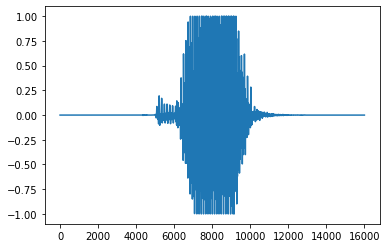

92874
audio
12


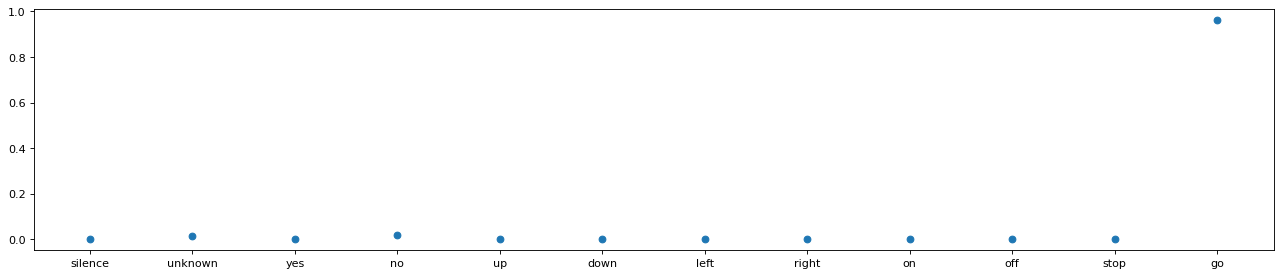

Predition go


In [152]:
index = random.randint(0, len(test_set))
#index = 67340
waveform, sample_rate, label,= test_set[index]

plt.plot(waveform.t().numpy());
plt.show()
waveform.shape


import IPython

print(index)
print(label)
print(len(softmaxs_test[index]))
figure(figsize=(20, 4), dpi=80)
plt.scatter([index_to_label(i) for i in range(0,len(softmaxs_test[index]))],softmaxs_test[index])
plt.show()
logits_argmax = softmaxs_test[index].argmax(dim = -1).squeeze()
print("Predition", index_to_label(int(logits_argmax)))
torchaudio.save('a.wav', waveform, 16000)
IPython.display.Audio("a.wav")

In [153]:
pred = prediction(model4,test_loader)

Testing: 100%|██████████| 620/620 [01:20<00:00,  7.69it/s]


In [154]:
filenames = [a.split("/")[1] for a in testset.getFilenames()]

In [155]:
pred_name = [index_to_label(a) for a in pred]

In [156]:
unique, counts = np.unique(pred_name, return_counts=True)

result = np.column_stack((unique, counts))
print (result)

[['down' '4836']
 ['go' '6647']
 ['left' '5909']
 ['no' '6926']
 ['off' '6231']
 ['on' '5992']
 ['right' '5353']
 ['silence' '14960']
 ['stop' '5721']
 ['unknown' '84081']
 ['up' '5887']
 ['yes' '5995']]


In [157]:
import pandas as pd
df = pd.DataFrame(
    {'fname': filenames,
     'label': pred_name,
    })

In [164]:
#test
label = "a"
while label != "up":
    i = random.randint(0, len(df))
    label  =  df.iloc[i]["label"]
filename = df.iloc[i]["fname"]

import IPython

print(label)
print(i)
IPython.display.Audio("test/audio/"+filename)


up
7563


In [ ]:
model_scripted = torch.jit.script(model4) # Export to TorchScript
model_scripted.save('model4_scripted.pt') #

model4 = torch.jit.load('../input/weights/model4_scripted.pt')
model4.eval()

In [165]:
df.to_csv('submission.csv', index=False)

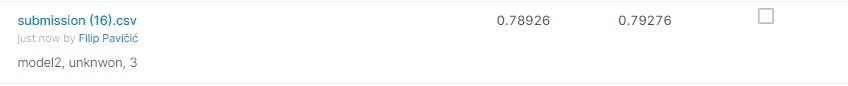